In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import RandomizedSearchCV

In [4]:
import ta
import talib
from tech_indicators import stoch,stoch_signal

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

## Preparing Data 


In [7]:
np.random.seed(999)

In [10]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')

In [13]:
def generate_tech_ind(fcpo_df):
    fcpo_df_tind=pd.DataFrame({
        'ema_slow':ta.trend.ema_slow(fcpo_df['Close'],n_slow=30).bfill(),
        'ema_fast':ta.trend.ema_fast(fcpo_df['Close'],n_fast=12).bfill(),
        'macd': ta.trend.macd(fcpo_df['Close']).bfill(),
        'macd_signal': ta.trend.macd_signal(fcpo_df['Close']).bfill(),
        'stoch' : stoch(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'stoch_signal' : stoch_signal(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'rsi':ta.momentum.rsi(fcpo_df['Close']).bfill(),
        'adx': ta.trend.adx(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'atr': ta.volatility.average_true_range(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill()
        #'find' : ta.volume.force_index(fcpo_df['Close'],fcpo_df['Volume']).bfill(),
        #'eom': ta.volume.ease_of_movement(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close'],fcpo_df['Volume'],n=10,fillna=True).bfill()
       })
    return fcpo_df_tind

In [14]:
## technical indicators are to be generate based on previous day's data
fcpo_daily_tind=generate_tech_ind(fcpo_data_daily[['Open','High','Low','Close','Volume']].shift(1))

## Using Prophet for forecasting

In [10]:
#from fbprophet import Prophet
#prophet_model=Prophet()
#prophet_data_df=fcpo_data_daily['Close'].reset_index()
#prophet_data_df=prophet_data_df.rename(columns={'Date':'ds','Close':'y'})
#prophet_model.fit(prophet_data_df)

#prophet_forecast=prophet_model.make_future_dataframe(periods=365)
#prophet_forecast=prophet_model.predict(prophet_forecast)
#prophet_model.plot(prophet_forecast)

## Machine Learning models

In [15]:
def build_modeling_data(fcpo_data_daily,fcpo_daily_tind,target_label='lprofit_ind',split_date='2017-01-01'):
    fcpo_train=fcpo_daily_tind[:split_date]
    fcpo_test = fcpo_daily_tind[split_date:]

    fcpo_train=fcpo_train.merge(fcpo_data_daily[['Open','next_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_traindata=fcpo_train.iloc[:,1:-1]
    fcpo_trainlabels=fcpo_train.iloc[:,-1:]
    
    fcpo_test=fcpo_test.merge(fcpo_data_daily[['Open','next_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_testdata=fcpo_test.iloc[:,1:-1]
    fcpo_testlabels=fcpo_test.iloc[:,-1]
    return fcpo_traindata,fcpo_trainlabels,fcpo_testdata,fcpo_testlabels

## Long call trading model 

In [16]:
fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,fcpo_lprofit_testdata,fcpo_lprofit_testlabels=build_modeling_data(fcpo_data_daily,
                                                                                                fcpo_daily_tind,'lprofit_ind','2016-01-01')

### Time-series cross validation

In [17]:
fcpo_tsplit=TimeSeriesSplit(n_splits=3)

In [21]:
### Compute cross-validation scores using time-series splits for a defined configuration ###
rf_lprofit= RandomForestClassifier(n_estimators=500,max_depth=12,min_samples_split=4,
                                  min_samples_leaf=4,max_features=4,criterion='entropy',bootstrap=False)

rf_lprofit_cval_scores=cross_val_score(rf_lprofit,fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels),
                                       scoring='roc_auc',cv=fcpo_tsplit)
rf_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=12, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [151]:
## Use the RandomSearch funciton to find the best hyper parameters of Random forrests
rf_param_dist = {"max_features": [4,8,12],
                  "min_samples_split": [2,4,6],
                  "min_samples_leaf": [1,2,4],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

In [152]:
rf_lprofit=RandomForestClassifier(n_estimators=500,max_depth=12,n_jobs=-1)
rf_lprofit_rsearch=RandomizedSearchCV(rf_lprofit,rf_param_dist,cv=fcpo_tsplit,scoring='roc_auc',
                                      n_iter=90,n_jobs=-1)

In [153]:
%%time
rf_lprofit_rsearch.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

CPU times: user 7.22 s, sys: 232 ms, total: 7.45 s
Wall time: 8min 29s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=90, n_jobs=-1,
          param_distributions={'max_features': [4, 8, 12], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [190]:
rf_lprofit_rsearch.best_params_

{'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 4,
 'criterion': 'entropy',
 'bootstrap': False}

In [22]:
rf_lprofit_test_proba=rf_lprofit.predict_proba(fcpo_lprofit_testdata)
rf_lprofit_test_predlabels=rf_lprofit.predict(fcpo_lprofit_testdata)

#### GBM

In [23]:
gbm_lprofit=GradientBoostingClassifier(n_estimators=200,max_depth=15,min_samples_leaf=4,
                                       min_samples_split=4,learning_rate=0.1)

gbm_lprofit_cval_scores=cross_val_score(gbm_lprofit,fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels),
                                       scoring='roc_auc',cv=fcpo_tsplit)

gbm_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

gbm_lprofit_test_proba=gbm_lprofit.predict_proba(fcpo_lprofit_testdata)
gbm_lprofit_test_predlabels=gbm_lprofit.predict(fcpo_lprofit_testdata)

## Short call trading model 

In [25]:
fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,fcpo_sprofit_testdata,fcpo_sprofit_testlabels=build_modeling_data(fcpo_data_daily,fcpo_daily_tind,'sprofit_ind','2016-01-01')

#### Random Forrest

In [26]:
rf_sprofit= RandomForestClassifier(n_estimators=500,max_depth=12,min_samples_split=4,
                                  min_samples_leaf=4,max_features=4,criterion='entropy')
rf_sprofit.fit(fcpo_sprofit_traindata,np.ravel(fcpo_sprofit_trainlabels))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
rf_sprofit=RandomForestClassifier()
rf_sprofit_rsearch=RandomizedSearchCV(rf_sprofit,rf_param_dist,cv=fcpo_tsplit,scoring='roc_auc',
                                      n_iter=100,n_jobs=3)

In [69]:
%%time
rf_sprofit_rsearch.fit(fcpo_sprofit_traindata,np.ravel(fcpo_sprofit_trainlabels))

CPU times: user 2.07 s, sys: 175 ms, total: 2.24 s
Wall time: 6min 48s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [50, 100, 200, 500], 'max_depth': [3, 10, 15], 'max_features': [5, 10, 12], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 3, 5], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [27]:
rf_sprofit_test_proba=rf_sprofit.predict_proba(fcpo_sprofit_testdata)
rf_sprofit_test_predlabels=rf_sprofit.predict(fcpo_sprofit_testdata)

#### GBM 

In [28]:
gbm_sprofit=GradientBoostingClassifier(n_estimators=200,max_depth=15,min_samples_leaf=4,
                                       min_samples_split=4,learning_rate=0.1)
gbm_sprofit.fit(fcpo_sprofit_traindata,np.ravel(fcpo_sprofit_trainlabels))

gbm_sprofit_test_proba=gbm_sprofit.predict_proba(fcpo_sprofit_testdata)
gbm_sprofit_test_predlabels=gbm_sprofit.predict(fcpo_sprofit_testdata)

## Evaluation of Models

### AUC and Confusion Matrix

In [29]:
roc_auc_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels)

0.5232042910447761

In [30]:
confusion_matrix(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels)

array([[ 46,  88],
       [ 57, 135]])

In [31]:
roc_auc_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels)

0.5329990671641791

In [32]:
confusion_matrix(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels)

array([[ 57,  77],
       [ 69, 123]])

In [33]:
roc_auc_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels)

0.49297664141414144

In [34]:
confusion_matrix(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels)

array([[ 26, 102],
       [ 43, 155]])

In [35]:
roc_auc_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels)

0.5013020833333333

In [36]:
confusion_matrix(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels)

array([[ 43,  85],
       [ 66, 132]])

## Financial Metrics

The final objective of this study is to improve the ROI, hence we are focused on creating a score-card to measure the investement metrics to select the final model,

- Total Returns
- Maximum Drawdown
- Number of Wins
- Number of Losses

**Calculation of Returns**

* When the sprofit_indicator is true, then return is (open_price - next_low_price) - (commission_price),
* Else when the sprofit_indicator is false, the model waits until the end of the day before selling it hence the return is (open_price - next_close_price) - (commission_price)


In [37]:
def calculate_short_returns(x,pred_field,commission_price,num_units):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        if x['sprofit_ind']==1:
        #when it is correct, sell it off when it reaches max x% profit zone
            return_myr=(min((x['Open']-x['Low']),(x['Open']-x['next_1low']),(x['Open']-x['Open']*0.98))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x['sprofit_ind']==0:
            return_myr=(max((x['Open']-x['next_1close']),(x['Open']-x['Open']*1.02))*num_units)-commission_price
    return return_myr

def calculate_long_returns(x,pred_field,commission_price,num_units):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        #when it is correct, sell it off when it reaches max x% profit zone
        if x['lprofit_ind']==1:
            return_myr=(min((x['High']-x['Open']),(x['next_1high']-x['Open']),(x['Open']*1.02-x['Open']))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x['lprofit_ind']==0:
            return_myr=(max((x['next_1close']-x['Open']),(x['Open']*0.98-x['Open']))*num_units)-commission_price
    return return_myr

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    mdd_peak=0
    mdd_x=0
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
            mdd_peak=peak
            mdd_x=x
    return mdd_peak,mdd_x,mdd 

In [46]:
fcpo_eval_df=fcpo_data_daily[['Open','High','Low','next_1low','next_1high','next_1close','lprofit_ind','sprofit_ind']].merge(
    pd.DataFrame(rf_lprofit_test_predlabels,columns=['rf_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_lprofit_test_predlabels,columns=['gbm_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_sprofit_test_predlabels,columns=['gbm_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(rf_sprofit_test_predlabels,columns=['rf_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True)

fcpo_eval_df['lprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_long_returns(x,'gbm_lprofit_prediction',30,20),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['lprofit_returns'].cumsum())

fcpo_eval_df['sprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_short_returns(x,'gbm_sprofit_prediction',30,20),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_sprofit_returns=fcpo_eval_df['sprofit_returns'].cumsum())

fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['cummulative_lprofit_returns']+15000,
            cummulative_sprofit_returns=fcpo_eval_df['cummulative_sprofit_returns']+15000)

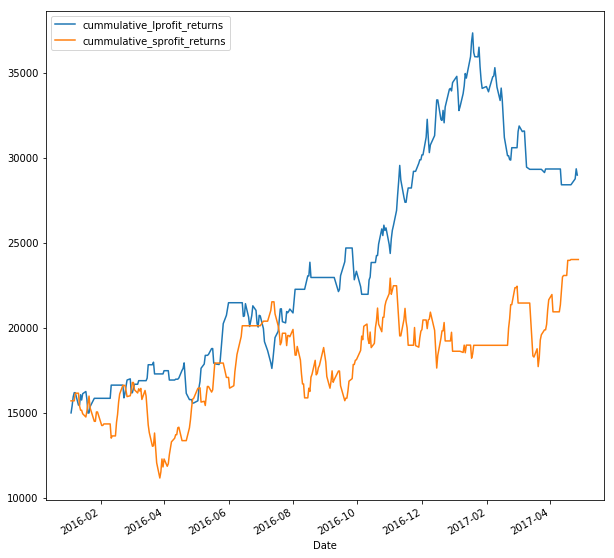

In [47]:
plt.figure(figsize=(10,10))
fcpo_eval_df['2016-01-01':'2017-05-01']['cummulative_lprofit_returns'].plot()
fcpo_eval_df['2016-01-01':'2017-05-01']['cummulative_sprofit_returns'].plot()
plt.legend()

In [48]:
max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns'])

(21485.600000000006, 17618.4, 0.17999031909744218)

In [49]:
max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns'])

(16790.399999999994, 11167.199999999979, 0.3349056603773595)